In [14]:
import itertools
import numpy as np
from pyomo.environ import *
from pyomo.environ import value as pyoval
from pyomo.environ import Binary, NonNegativeReals, UnitInterval, Reals
from typing import Tuple, Union
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from matplotlib import rc 

In [15]:
def active_set_method(A:np.ndarray, b:np.ndarray, theta_nominal:list, theta_deviations:list, design_vectors:np.ndarray | list[np.ndarray]=None, z_bounds:list[Tuple]=None, bigM:float=1e3, model_only:bool=False):
    """
    From:
    A(d, z, theta) <= b
    z_lb <= z <= z_ub
    theta_nominal - delta * theta_deviations_lb <= theta <= theta_nominal + delta * theta_deviations_ub
    
    Convert to:
    h(d, z, theta, slack, dual, binary) == b_h
    g(z, theta, slack, dual, binary, delta) <= b_g

    Args:
        A: Coefficient matrix of system equations
        b: Vector of constant values
        theta_nominal: Nominal values of uncertain parameters
        theta_deviations: Allowable changes from the nominal value (lower bound, upper bound)
        design_vectors: Values of design variables
        z_bounds: Bounds on control variables
        bigM: Big M value 
        model_only: Boolean value. If True, returns an unsolved active set model

    Returns:
        m: Pyomo model
        delta: Flexibility index value
    """
    if not (isinstance(theta_nominal, list) and isinstance(theta_deviations, list) and all(isinstance(t, tuple) and len(t)==2 and all(isinstance(x, (int, float)) for x in t) for t in theta_deviations)):
        raise ValueError('Please provide a list (of length n_t) of tuples (of size 2) and containing only float or integer values!')
    elif len(theta_nominal) != len(theta_deviations):
        raise ValueError('Inconsistent input for nominal theta values and theta bounds')
    
    n_t = len(theta_nominal)
    n_d = design_vectors[0].shape[0] if isinstance(design_vectors, list) else design_vectors.shape[0] if isinstance(design_vectors, np.ndarray) else 0
    n_c = A.shape[1] - n_t - n_d
    if n_c < 0:
        raise ValueError('Inconsistent coefficients input')
    if isinstance(z_bounds, list):        
        if not (len(z_bounds) == n_c and all(isinstance(t, tuple) and len(t)==2 and all(isinstance(x, (int, float)) for x in t) for t in z_bounds)):
            raise ValueError('Please provide a list (of length n_c) of tuples (of size 2) and containing only float or integer values!')
    
    # Reformulate A(d, z, theta) <= b to h(d, z, theta, slack, dual, binary) == b_h
    # h1(d, z, theta, slack) == b               for all system constraints
    # h2(dual) == 0 (from dA/dz = 0)            for all control variables
    # h3(dual, binary) == [1, n_c+1]'           2 constraints
    # d == dE                                   for all design variables - if provided
    # b_h = [b, 0*n_c, 1, n_c+1, dE (if provided)]'
    h1 = np.concatenate([A, np.diag([1]*A.shape[0]), np.zeros((A.shape[0], 2*A.shape[0]))], axis=1)
    h2 = np.concatenate([np.zeros((n_c, A.shape[1]+A.shape[0])), A[:, n_d:n_d+n_c].T, np.zeros((n_c, A.shape[0]))], axis=1)
    h3 = np.concatenate([np.zeros((2, A.shape[1]+A.shape[0])), np.stack([np.ones(A.shape[0]).T, np.zeros(A.shape[0]).T], axis=0), np.stack([np.zeros(A.shape[0]).T, np.ones(A.shape[0]).T], axis=0)], axis=1)
    h = np.concatenate([h1, h2, h3], axis=0)
    b_h = np.concatenate([b, np.zeros(n_c), np.array([1]), np.array([n_c+1])], axis=0)
    
    # Add inequalities for the active set reformulation g(z, theta, slack, dual, binary, delta) <= b_g
    # z <= z_UB                                             Upper bounds for all control variables
    # -z <= -z_LB                                           Lower bounds for all control variables
    # theta - theta_bound*delta <= theta_nominal            Upper bounds for all uncertain parameters
    # -theta - theta_bound*delta <= -theta_nominal          Lower bounds for all uncertain parameters
    # slack + bigM*binary <= bigM                           # bigM reformulation of complementary conditions
    # dual - binary <= 0                                    bigM reformulation of complementary conditions
    g1 = np.concatenate([np.concatenate([np.diag([1]*n_t), np.diag([-1]*n_t)], axis=0), np.zeros((2*n_t, 3*A.shape[0])), np.stack([-np.array([i[1] for i in theta_deviations]), -np.array([i[1] for i in theta_deviations])], axis=0).reshape(-1,1)], axis=1)
    g2 = np.concatenate([np.zeros((A.shape[0], n_t)), np.diag([1]*A.shape[0]), np.diag([0]*A.shape[0]), np.diag([bigM]*A.shape[0]), np.zeros(A.shape[0]).reshape(-1,1)], axis=1)
    g3 = np.concatenate([np.zeros((A.shape[0], n_t)), np.diag([0]*A.shape[0]), np.diag([1]*A.shape[0]), np.diag([-1]*A.shape[0]), np.zeros(A.shape[0]).reshape(-1,1)], axis=1)
    g = np.concatenate([g1, g2, g3], axis=0)
    b_g = np.concatenate([np.array(theta_nominal), -np.array(theta_nominal), np.array([bigM]*A.shape[0]), np.array([0]*A.shape[0])], axis=0)
    g_shift=n_d+n_c
    
    def evaluate_delta_fixed_design(h, b_h, g, b_g, g_shift, z_b:np.ndarray=None, design_vector:np.ndarray=None):
        if isinstance(design_vector, np.ndarray):
            h4 = np.concatenate([np.diag([1]*n_d), np.zeros((n_d, n_c+n_t+3*A.shape[0]))], axis=1)
            h_new, b_h_new = np.concatenate([h, h4], axis=0), np.concatenate([b_h, design_vector], axis=0)
        else:
            h_new, b_h_new= h, b_h
            
        if isinstance(z_b, list):
            g0 = np.concatenate([np.concatenate([np.diag([1]*n_c), np.diag([-1]*n_c)], axis=0), np.zeros((2*n_c, n_t+3*A.shape[0]+1))], axis=1)
            gz = np.zeros((2*(n_t+A.shape[0]), n_c))
            b0 = np.array([i[1] for i in z_bounds]+[-i[0] for i in z_bounds])
            g_new, b_g_new = np.concatenate([g0, np.concatenate([gz, g], axis=1)], axis=0), np.concatenate([b0, b_g], axis=0)
            g_shift=n_d
        else:
            g_new, b_g_new = g, b_g
                
        binary_indexes = [i for i in range(A.shape[1]+2*A.shape[0]+1, A.shape[1]+3*A.shape[0]+1)]
        def var_domain_rule(instance, i):
            return Binary if i in binary_indexes else NonNegativeReals
        
        m = ConcreteModel()
        m.v = RangeSet(n_d+n_c+n_t+3*A.shape[0]+1)
        m.var = Var(m.v, domain=var_domain_rule)        # order of variables (design, control, theta, slack, dual, binary, delta)
        m.hi = RangeSet(h_new.shape[0])
        m.hj = RangeSet(h_new.shape[1])
        m.gi = RangeSet(g_new.shape[0])
        m.gj = RangeSet(g_new.shape[1])

        def h_eq_bh_rule(instance, i):
            return sum(h_new[i-1, j-1]*instance.var[j] for j in instance.hj) == b_h_new[i-1]
        m.h_eq_bh = Constraint(m.hi, rule=h_eq_bh_rule)
        
        def g_leq_bg_rule(instance, i):
            return sum(g_new[i-1, j-1]*instance.var[j+g_shift] for j in instance.gj) <= b_g_new[i-1]
        m.g_leq_bg = Constraint(m.gi, rule=g_leq_bg_rule)
        
        # Objective
        m.objective = Objective(expr=m.var[len(m.v)], sense=minimize)
        # m.cuts = ConstraintList()
        # m.cuts.add(m.var[11] + m.var[12] - m.var[13] <= 1)
        solver = SolverFactory('gurobi')
        solver.solve(m)
        actives = [j-(A.shape[1]+2*A.shape[0]) for j in binary_indexes if pyoval(m.var[j]) == 1] # Adjust for constraint number
        return m, pyoval(m.var[len(m.v)]), actives
    
    if isinstance(design_vectors, list):
        m, delta, active_set = [defaultdict(dict) for _ in range(3)]
        for i in range(len(design_vectors)):
            m[i], delta[i], active_set[i] = evaluate_delta_fixed_design(h=h, b_h=b_h, g=g, b_g=b_g, g_shift=g_shift, z_b=z_bounds, design_vector=design_vectors[i])
    elif isinstance(design_vectors, np.ndarray):
        m, delta, active_set = evaluate_delta_fixed_design(h=h, b_h=b_h, g=g, b_g=b_g, g_shift=g_shift, z_b=z_bounds, design_vector=design_vectors)
    else:
        m, delta, active_set = evaluate_delta_fixed_design(h=h, b_h=b_h, g=g, b_g=b_g, g_shift=g_shift)
    
    return m, delta, active_set

In [16]:
def model_relaxation(m:ConcreteModel, aset:list, n_vars:int, n_cons:int, n_t:int, n_d:int, z_b:list=None):
    relax_m = copy.deepcopy(m)
    for var in relax_m.component_data_objects(Var, descend_into=True):
        if var.domain is Binary:
            var.domain = UnitInterval
            var.fix(pyoval(var))
    for v in relax_m.var:
        if v in range(1, n_d+1):
            relax_m.var[v].fix(pyoval(m.var[v]))
        elif v in range(n_vars+1, 2*n_vars+1):
            relax_m.var[v].fix(0)
        elif v in range(2*n_vars+1, 3*n_vars+1):
            relax_m.var[v].fix(pyoval(m.var[v]))
    for idx in relax_m.h_eq_bh:
        if idx not in aset:
            relax_m.h_eq_bh[idx].deactivate()
    start = len(z_b) if isinstance(z_b, list) else 0
    end = start + 2*n_t
    g_as = list(range(start+1, end+1))
    for idx in relax_m.g_leq_bg:
        if idx not in g_as:
            relax_m.g_leq_bg[idx].deactivate()
    if hasattr(relax_m, 'cuts'):
        for idx in relax_m.cuts:
            relax_m.cuts[idx].deactivate()
    relax_m.dual = Suffix(direction=Suffix.IMPORT)
    SolverFactory('gurobi').solve(relax_m)
    duals = np.array([relax_m.dual[relax_m.h_eq_bh[i]] if i in aset else 0 for i in range(1, n_cons+1)])
    return relax_m, duals

In [17]:
def flex_optimization(fix_cost:list, var_cost:list, delta0:dict, sigma_array:np.ndarray, ddesign_bounds:list[Tuple]):
    mflex = ConcreteModel()
    mflex.actsets = RangeSet(sigma_array.shape[1])
    mflex.dsets = RangeSet(sigma_array.shape[0])
    
    mflex.delta_k = Var(mflex.actsets, within=NonNegativeReals)
    mflex.delta_d = Var(mflex.dsets, within=NonNegativeReals) #Reals
    mflex.w = Var(mflex.dsets, within=Binary)
    mflex.cost = Var(within=NonNegativeReals)
    mflex.F = Var(within=NonNegativeReals)
    
    def flex_index_rule(instance, as_k):
        return instance.F <= instance.delta_k[as_k]
    mflex.flex_index_cons = Constraint(mflex.actsets, rule=flex_index_rule)
    
    def delta_k_rule(instance, as_k):
        return instance.delta_k[as_k] == delta0[as_k] + sum(sigma_array[i-1, as_k-1]*instance.delta_d[i] for i in instance.dsets)
    mflex.delta_k_cons = Constraint(mflex.actsets, rule=delta_k_rule)
    
    def delta_d_LB_rule(instance, d_r):
        return -ddesign_bounds[d_r-1][0]*instance.w[d_r] <= instance.delta_d[d_r]
    mflex.delta_d_LB_cons = Constraint(mflex.dsets, rule=delta_d_LB_rule)
    
    def delta_d_UB_rule(instance, d_r):
        return instance.delta_d[d_r] <= ddesign_bounds[d_r-1][1]*instance.w[d_r]
    mflex.delta_d_UB_cons = Constraint(mflex.dsets, rule=delta_d_UB_rule)
    
    def cost_rule(instance):
        return instance.cost == sum(fix_cost[i-1]*mflex.w[i] + var_cost[i-1]*mflex.delta_d[i] for i in mflex.dsets)
    mflex.cost_con = Constraint(rule=cost_rule)
    
    mflex.objective = Objective(expr=mflex.F, sense=maximize)
    SolverFactory('gurobi').solve(mflex)
    
    return mflex, pyoval(mflex.cost), np.array([pyoval(mflex.delta_d[i]) for i in mflex.dsets]), pyoval(mflex.F)
    

In [18]:
def cost_optimization(fix_cost:list, var_cost:list, flex_target:float, sigma_array:np.ndarray, ddesign_bounds:list[Tuple], delta0:dict):
    mcost = ConcreteModel()
    mcost.actsets = RangeSet(sigma_array.shape[1])
    mcost.dsets = RangeSet(sigma_array.shape[0])
    
    mcost.delta_k = Var(mcost.actsets, within=NonNegativeReals)
    mcost.delta_d = Var(mcost.dsets, within=NonNegativeReals) # Reals
    mcost.w = Var(mcost.dsets, within=Binary)
    print(delta0)
    
    def flex_target_rule(instance, aset_k):
        return instance.delta_k[aset_k] >= flex_target
    mcost.flex_target_cons = Constraint(mcost.actsets, rule=flex_target_rule)
    
    def delta_k_rule(instance, as_k):
        return instance.delta_k[as_k] == delta0[as_k] + sum(sigma_array[i-1, as_k-1]*instance.delta_d[i] for i in instance.dsets)
    mcost.delta_k_cons = Constraint(mcost.actsets, rule=delta_k_rule)
    
    def delta_d_LB_rule(instance, d_r):
        return -ddesign_bounds[d_r-1][0]*instance.w[d_r] <= instance.delta_d[d_r]
    mcost.delta_d_LB_cons = Constraint(mcost.dsets, rule=delta_d_LB_rule)
    
    def delta_d_UB_rule(instance, d_r):
        return instance.delta_d[d_r] <= ddesign_bounds[d_r-1][1]*instance.w[d_r]
    mcost.delta_d_UB_cons = Constraint(mcost.dsets, rule=delta_d_UB_rule)
    
    mcost.objective = Objective(expr = sum(fix_cost[i-1]*mcost.w[i] + var_cost[i-1]*mcost.delta_d[i] for i in mcost.dsets), sense=minimize)
    result_mcost = SolverFactory('gurobi').solve(mcost)
    if result_mcost.solver.termination_condition == TerminationCondition.infeasibleOrUnbounded:
        return result_mcost, mcost, None

    return result_mcost, mcost, np.array([pyoval(mcost.delta_d[i]) for i in mcost.dsets])
        

In [19]:
def algorithm2(A:np.ndarray, b:np.ndarray, theta_nominal:list, theta_deviations:list, fix_cost:list, var_cost:list, ddesign_bounds:list[Tuple], design_vectors:np.ndarray | list[np.ndarray]=None, z_bounds:list[Tuple]=None, bigM:float=1e3, flex_target:float=1.0, solve_mp:bool=False):
    
    n_t = len(theta_nominal)
    n_d = design_vectors[0].shape[0] if isinstance(design_vectors, list) else design_vectors.shape[0] if isinstance(design_vectors, np.ndarray) else 0
    n_c = A.shape[1] - n_t - n_d
    binary_shift = A.shape[1]+2*A.shape[0]
    binary_indexes = [i for i in range(binary_shift+1, binary_shift+A.shape[0]+1)]
    if n_c < 0:
        raise ValueError('Inconsistent coefficients input')
    final_cost = 0
    final_design_array = design_vectors
    print(f'Starting analysis for flexibility target of {flex_target}')
    
    while True:
        delta_dict, actset_dict, dual_dict, k = dict(), dict(), dict(), 1
        # Step 1: Solving active set problem to initialize algorithm
        m_as, delta_dict[k], actset_dict[k] =active_set_method(A=A, b=b, theta_nominal=theta_nominal, theta_deviations=theta_deviations, design_vectors=final_design_array, z_bounds=z_bounds, bigM=bigM)
        print(f'Active set {k}: {actset_dict[k]}')
        print(f'Flexibility index for active set {k}: {delta_dict[k]}')
        mrelax_as, dual_dict[k] = model_relaxation(m=m_as, aset=actset_dict[k], n_vars=A.shape[1], n_t=n_t, z_b=z_bounds, n_cons=A.shape[0], n_d=n_d)
        print(f'Dual variables for relaxed active set {k}: {dual_dict[k]}')
        if round(delta_dict[k],5) >= round(flex_target,5):
            print(f'Flexibility Target {flex_target} Achieved')
            return m_as, final_cost, final_design_array, delta_dict[k]
        
        while round(delta_dict[k],5) < round(flex_target,5):
            k+=1
            if not hasattr(m_as,'cuts'):
                m_as.cuts = ConstraintList()
            m_as.cuts.add(sum(m_as.var[j] for j in binary_indexes if pyoval(m_as.var[j]==1)) - sum(m_as.var[j] for j in binary_indexes if pyoval(m_as.var[j]==0)) <= n_c)
            SolverFactory('gurobi').solve(m_as)
            delta_dict[k] = pyoval(m_as.var[len(m_as.v)])
            actset_dict[k] = [j-binary_shift for j in binary_indexes if pyoval(m_as.var[j]) == 1]
            print(f'Active set {k}: {actset_dict[k]}')
            print(f'Flexibility index for active set {k}: {delta_dict[k]}')
            mrelax_as, dual_dict[k] = model_relaxation(m=m_as, aset=actset_dict[k], n_vars=A.shape[1], n_t=n_t, z_b=z_bounds, n_cons=A.shape[0], n_d=n_d)
            print(f'Dual variables for relaxed active set {k}: {dual_dict[k]}')
        
        # Step 3: Calculating sensitivity coefficients (sigma)
        dual_arrays = np.empty((A.shape[0], 0))
        for key, arr in dual_dict.items():
            dual_arrays = np.hstack((dual_arrays, arr.reshape(-1,1)))
        sigma = -dual_arrays.T@A[:, :n_d]
        # print(f'Sigma: {sigma}')
        
        # Step 4: Solve cost optimization problem
        result_cost, m_cost, delta_d = cost_optimization(fix_cost=fix_cost, var_cost=var_cost, flex_target=flex_target, sigma_array=sigma, ddesign_bounds=ddesign_bounds, delta0=delta_dict)
        if result_cost.solver.termination_condition == TerminationCondition.infeasibleOrUnbounded:
            print('Here')
            m_flex, final_cost, delta_d, flex_index = flex_optimization(fix_cost=fix_cost, var_cost=var_cost, delta0=delta_dict, sigma_array=sigma, ddesign_bounds=ddesign_bounds)
            final_design_array = design_vectors+delta_d
            print('Flexibility Target unachievable for current design retrofit bounds!!')
            print(f'Maximum possible flexibility: {flex_index}, achieved at cost: {final_cost}, with design vector: {final_design_array}')
            return m_flex, final_cost, final_design_array, flex_index
        
        print(f'Required changes in design: {delta_d}')
        final_cost = pyoval(m_cost.objective)
        final_design_array = design_vectors + delta_d

In [20]:
def iter_algorithm2(flex_target_range:list, discretizations:int):
    target_list = list(np.linspace(flex_target_range[0], flex_target_range[1], discretizations))
    cost_list, d1_list, d2_list = list(), list(), list()
    for target in target_list:
        model, cost_final, design_final, flex_index = algorithm2(A=A, b=b, theta_nominal=theta_nominal, theta_deviations=theta_deviations, design_vectors=d, fix_cost=c, var_cost=beta, ddesign_bounds=delta_design_bounds, flex_target=target)
        cost_list.append(cost_final), d1_list.append(float(design_final[0])), d2_list.append(float(design_final[1]))
    return target_list, cost_list, d1_list, d2_list

In [21]:
# EXAMPLE 1 Pistikopoulos and Grossmann (1988): https://www.sciencedirect.com/science/article/pii/0098135488800103
theta_nominal = [2]
theta_deviations = [(2,2)]
A = np.array([
    [1, -3, 1, -1],
    [0, 1, -1, -1/3],
    [-1, 0, 1 ,1]
])
b = np.array([0, -1/3, 1])
d = np.array([3, 1])
c = np.zeros(d.shape[0])
beta = np.array([10]*d.shape[0])
delta_design_bounds=[(1000, 1000), (1000, 1000)]
flex_target = 0.552

In [22]:
model, cost_final, design_final, flex_index = algorithm2(A=A, b=b, theta_nominal=theta_nominal, theta_deviations=theta_deviations, design_vectors=d, fix_cost=c, var_cost=beta, ddesign_bounds=delta_design_bounds, flex_target=flex_target)

Starting analysis for flexibility target of 0.552
Active set 1: [1, 2]
Flexibility index for active set 1: 0.5
Dual variables for relaxed active set 1: [0.375 0.375 0.   ]
Active set 2: [2, 3]
Flexibility index for active set 2: 1.0
Dual variables for relaxed active set 2: [0.   0.75 0.75]
{1: 0.5, 2: 1.0}
Required changes in design: [0.         0.06933333]
Active set 1: [1, 2]
Flexibility index for active set 1: 0.552
Dual variables for relaxed active set 1: [0.375 0.375 0.   ]
Flexibility Target 0.552 Achieved


In [23]:
# deltas, costs, d1s, d2s = iter_algorithm2(flex_target_range=[0.5, 1.0], discretizations=50)

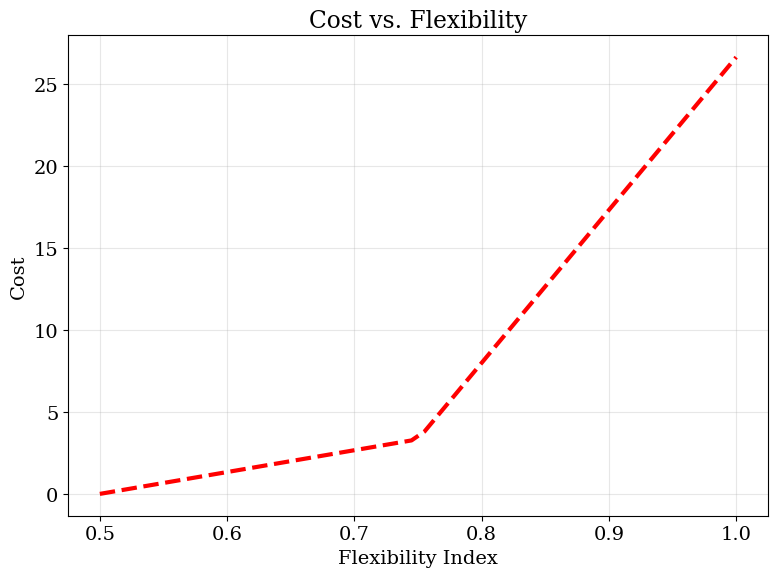

In [24]:
rc('font', **{'family': 'serif', 'size': 14})

fig, ax = plt.subplots(figsize = (8, 6))
# Plotting
ax.plot(deltas, costs, marker='', color = 'red', linestyle='--', linewidth = 3)  # 'o' adds circular markers at data points
plt.title('Cost vs. Flexibility')
plt.ylabel('Cost')
plt.xlabel('Flexibility Index')
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()
plt.rcdefaults()

In [25]:
d1s = [i-d[0] for i in d1s]
d2s = [j-d[1] for j in d2s]

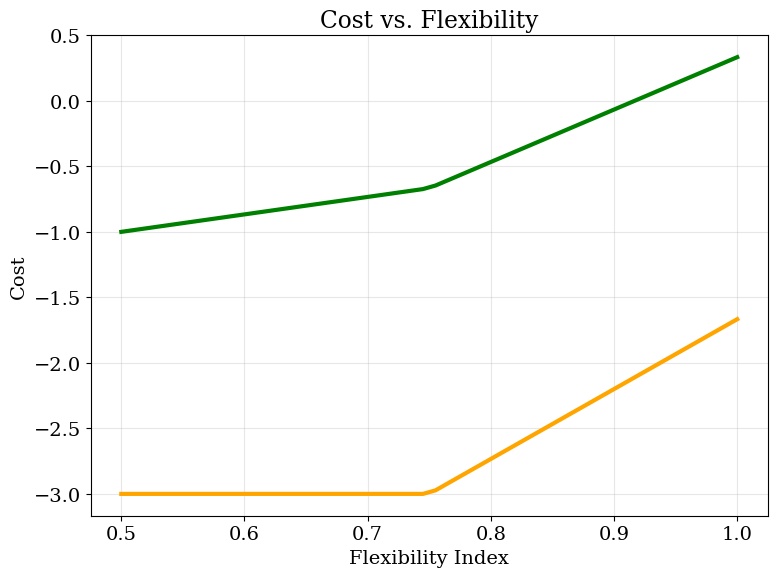

In [26]:
rc('font', **{'family': 'serif', 'size': 14})

fig, ax = plt.subplots(figsize = (8, 6))
# Plotting
ax.plot(deltas, d1s, marker='', color = 'orange', linewidth = 3)  # 'o' adds circular markers at data points
ax.plot(deltas, d2s, marker='', color = 'green', linewidth = 3) 
plt.title('Cost vs. Flexibility')
plt.ylabel('Cost')
plt.xlabel('Flexibility Index')
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()
plt.rcdefaults()